Запустить seq2seq, seq2seq с внимаием для перевода русских слов + описать наблюдения по качеству <br>
Данные в папке data

### без внимания

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

import re
import tensorflow.compat.v1 as tf

In [2]:
batch_size = 64
epochs = 50
latent_dim = 256
num_samples = 10000
data_path = 'data/rus-eng/rus.txt'

In [3]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])


input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [4]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [5]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [6]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Epoch 1/50
125/125 [==============================] - 35s 277ms/step - loss: 1.1225 - accuracy: 0.7737 - val_loss: 0.9152 - val_accuracy: 0.7596
Epoch 2/50
125/125 [==============================] - 34s 273ms/step - loss: 0.7344 - accuracy: 0.8025 - val_loss: 0.7773 - val_accuracy: 0.7944
Epoch 3/50
125/125 [==============================] - 34s 270ms/step - loss: 0.6309 - accuracy: 0.8336 - val_loss: 0.6855 - val_accuracy: 0.8135
Epoch 4/50
125/125 [==============================] - 34s 274ms/step - loss: 0.5615 - accuracy: 0.8453 - val_loss: 0.6277 - val_accuracy: 0.8244
Epoch 5/50
125/125 [==============================] - 34s 269ms/step - loss: 0.5224 - accuracy: 0.8531 - val_loss: 0.5948 - val_accuracy: 0.8307
Epoch 6/50
125/125 [==============================] - 34s 273ms/step - loss: 0.5596 - accuracy: 0.8495 - val_loss: 0.6026 - val_accuracy: 0.8270
Epoch 7/50
125/125 [==============================] - 33s 263ms/step - loss: 0.5005 - accuracy: 0.8575 - val_loss: 0.5699 - val_ac

-
Input sentence: Fire!
Decoded sentence: Отони!

-
Input sentence: Fire!
Decoded sentence: Отони!

-
Input sentence: Help!
Decoded sentence: Смот!

-
Input sentence: Help!
Decoded sentence: Смот!

-
Input sentence: Help!
Decoded sentence: Смот!

-
Input sentence: Jump!
Decoded sentence: Прыгайте!

-
Input sentence: Jump!
Decoded sentence: Прыгайте!

-
Input sentence: Jump.
Decoded sentence: Прыгайте!

-
Input sentence: Jump.
Decoded sentence: Прыгайте!

-
Input sentence: Stop!
Decoded sentence: Остановитесь!

-
Input sentence: Stop!
Decoded sentence: Остановитесь!

-
Input sentence: Stop!
Decoded sentence: Остановитесь!

-
Input sentence: Wait!
Decoded sentence: Ждите!

-
Input sentence: Wait!
Decoded sentence: Ждите!

-
Input sentence: Wait!
Decoded sentence: Ждите!

-
Input sentence: Wait!
Decoded sentence: Ждите!

-
Input sentence: Wait.
Decoded sentence: Подождите.

-
Input sentence: Wait.
Decoded sentence: Подождите.

-
Input sentence: Wait.
Decoded sentence: Подождите.

-
Input 

### c вниманием

In [130]:
data_path = 'data/rus-eng/rus.txt'
num_samples = 10000

tf.enable_eager_execution()

input_texts = []
target_texts = []

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence(target_text))

In [131]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [132]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [133]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [134]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [135]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [136]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [137]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [138]:
EPOCHS = 50
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 1.6834
Epoch 2 Loss 1.2709
Epoch 3 Loss 1.0974
Epoch 4 Loss 0.9577
Epoch 5 Loss 0.8320
Epoch 6 Loss 0.7154
Epoch 7 Loss 0.6107
Epoch 8 Loss 0.5175
Epoch 9 Loss 0.4331
Epoch 10 Loss 0.3617
Epoch 11 Loss 0.3058
Epoch 12 Loss 0.2636
Epoch 13 Loss 0.2343
Epoch 14 Loss 0.2104
Epoch 15 Loss 0.1932
Epoch 16 Loss 0.1846
Epoch 17 Loss 0.1724
Epoch 18 Loss 0.1640
Epoch 19 Loss 0.1593
Epoch 20 Loss 0.1533
Epoch 21 Loss 0.1487
Epoch 22 Loss 0.1454
Epoch 23 Loss 0.1427
Epoch 24 Loss 0.1404
Epoch 25 Loss 0.1386
Epoch 26 Loss 0.1370
Epoch 27 Loss 0.1340
Epoch 28 Loss 0.1319
Epoch 29 Loss 0.1294
Epoch 30 Loss 0.1273
Epoch 31 Loss 0.1258
Epoch 32 Loss 0.1258
Epoch 33 Loss 0.1246
Epoch 34 Loss 0.1243
Epoch 35 Loss 0.1229
Epoch 36 Loss 0.1224
Epoch 37 Loss 0.1208
Epoch 38 Loss 0.1199
Epoch 39 Loss 0.1182
Epoch 40 Loss 0.1171
Epoch 41 Loss 0.1157
Epoch 42 Loss 0.1152
Epoch 43 Loss 0.1159
Epoch 44 Loss 0.1158
Epoch 45 Loss 0.1199
Epoch 46 Loss 0.1196
Epoch 47 Loss 0.1181
Epoch 48 Loss 0.1144
E

In [139]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Populating the interactive namespace from numpy and matplotlib


C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Input: <start> hello how are you <end>
Predicted translation: как ты . <end> 


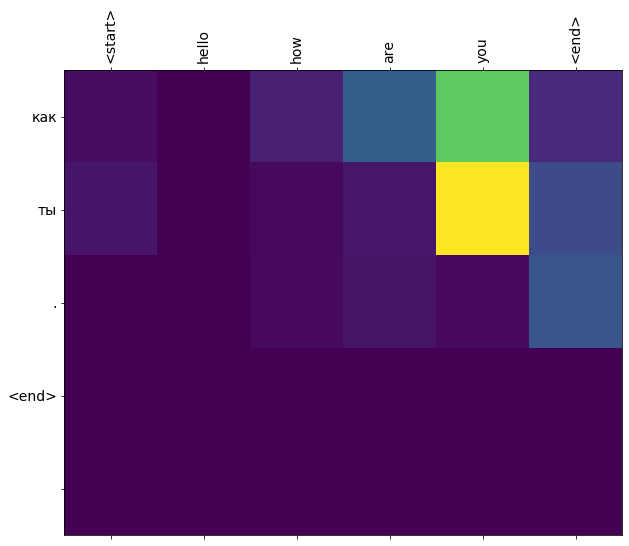

In [140]:
%pylab inline

translate(u'hello how are you')

### без внимания

попробуем запустить аналогичный код без внимания

In [141]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        #self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        #context_vector, attention_weights = self.attention(hidden, enc_output)
        attention_weights = 0
        x = self.embedding(x)
        #x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [142]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [143]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [144]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [145]:
EPOCHS = 50
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 1.9355
Epoch 2 Loss 1.3746
Epoch 3 Loss 1.2993
Epoch 4 Loss 1.2368
Epoch 5 Loss 1.1804
Epoch 6 Loss 1.1347
Epoch 7 Loss 1.0973
Epoch 8 Loss 1.0645
Epoch 9 Loss 1.0375
Epoch 10 Loss 1.0153
Epoch 11 Loss 0.9991
Epoch 12 Loss 0.9837
Epoch 13 Loss 0.9733
Epoch 14 Loss 0.9654
Epoch 15 Loss 0.9584
Epoch 16 Loss 0.9544
Epoch 17 Loss 0.9500
Epoch 18 Loss 0.9470
Epoch 19 Loss 0.9440
Epoch 20 Loss 0.9417
Epoch 21 Loss 0.9401
Epoch 22 Loss 0.9385
Epoch 23 Loss 0.9370
Epoch 24 Loss 0.9364
Epoch 25 Loss 0.9339
Epoch 26 Loss 0.9333
Epoch 27 Loss 0.9324
Epoch 28 Loss 0.9314
Epoch 29 Loss 0.9306
Epoch 30 Loss 0.9294
Epoch 31 Loss 0.9289
Epoch 32 Loss 0.9283
Epoch 33 Loss 0.9278
Epoch 34 Loss 0.9270
Epoch 35 Loss 0.9267
Epoch 36 Loss 0.9258
Epoch 37 Loss 0.9253
Epoch 38 Loss 0.9248
Epoch 39 Loss 0.9244
Epoch 40 Loss 0.9237
Epoch 41 Loss 0.9236
Epoch 42 Loss 0.9225
Epoch 43 Loss 0.9225
Epoch 44 Loss 0.9222
Epoch 45 Loss 0.9217
Epoch 46 Loss 0.9211
Epoch 47 Loss 0.9208
Epoch 48 Loss 0.9207
E

Populating the interactive namespace from numpy and matplotlib
Input: <start> hello how are you <end>
Predicted translation: я не могу это . <end> 


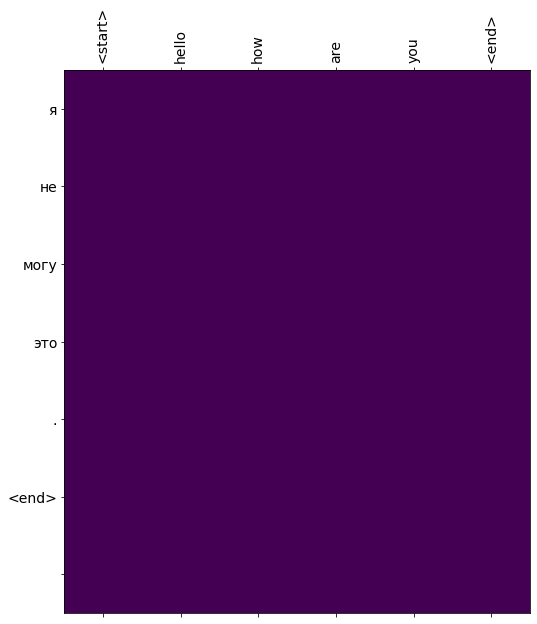

In [146]:
%pylab inline

translate(u'hello how are you')

Вывод - метод с вниманием работает лучше. это видно и по переводу и по Loss 